In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
from pprint import pprint

import pickle
import gensim
from gensim.models.ldamulticore import LdaMulticore
from gensim import corpora, models
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim_models

import string

import warnings
warnings.simplefilter('ignore')
from itertools import chain
from sklearn.feature_extraction.text import CountVectorizer
from tqdm import tqdm
from tqdm.auto import tqdm

import datetime as dt
import os
from dateutil.relativedelta import *

In [2]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

## Define Functions

In [3]:
def clean(text):
#     from nltk.corpus import stopwords
#     from nltk.stem import WordNetLemmatizer
    
    exclude = set(string.punctuation)
    stop = set(stopwords.words('english'))
    lemma = WordNetLemmatizer()
    
    text = re.sub('[^A-z,.-]+', ' ', text)

    stop_free = ' '.join([word for word in text.lower().split() if word not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = ' '.join([lemma.lemmatize(word) for word in punc_free.split()])
    return normalized.split()

def bigrams(words, bi_min=15, tri_min=10):
    bigram = gensim.models.Phrases(words, min_count = bi_min)
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    return bigram_mod
    
def get_corpus(text_clean):
    bigram_mod = bigrams(text_clean)
    bigram = [bigram_mod[review] for review in text_clean]
    id2word = gensim.corpora.Dictionary(bigram)
    id2word.filter_extremes(no_below=10, no_above=0.35)
    id2word.compactify()
    corpus = [id2word.doc2bow(text) for text in bigram]
    return corpus, id2word, bigram


def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    from gensim.models.ldamodel import LdaModel
    """
    # From https://datascienceplus.com/evaluation-of-topic-modeling-topic-coherence/
    
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model=LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, passes = 4)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

## Load Preprocessed Data

In [4]:
# Load nontext data
file = open('../data/preprocessed/nontext_data.pickle', 'rb')
nontext_data = pd.read_pickle(file)
file.close()

print(nontext_data.shape)
nontext_data.head()

(396, 57)


,unscheduled,forecast,confcall,Rate,RateDiff,RateDecision,ChairPerson,RateChanged,GDP_date,GDP_value,...,Hsales_diff_year,Taylor,Balanced,Inertia,Taylor-Rate,Balanced-Rate,Inertia-Rate,Taylor_diff,Balanced_diff,Inertia_diff
date,,,,,,,,,,,,,,,,,,,,,
1982-10-05,False,False,False,9.5,-0.5,-1,NaN,1,1982-04-01,6830.251,...,42.307692,7.428054,4.300007,7.854999,-2.571946,-5.699993,-2.145001,NaN,NaN,NaN
1982-11-16,False,False,False,9.0,-0.5,-1,NaN,1,1982-07-01,6804.139,...,34.831461,6.397952,2.690992,7.671351,-3.102048,-6.809008,-1.828649,-1.030102,-1.609015,-0.183648
1982-12-21,False,False,False,8.5,0.0,0,NaN,0,1982-07-01,6804.139,...,45.026178,6.456348,2.749388,6.812592,-2.043652,-5.750612,-1.687408,0.058396,0.058396,-0.858759
1983-01-14,False,False,True,8.5,0.0,0,NaN,0,1982-07-01,6804.139,...,14.004376,6.117343,2.410384,6.863442,-2.382657,-6.089616,-1.636558,-0.339005,-0.339005,0.050851
1983-01-21,False,False,True,8.5,0.0,0,NaN,0,1982-07-01,6804.139,...,14.004376,6.117343,2.410384,6.863442,-2.382657,-6.089616,-1.636558,0.000000,0.000000,0.000000


In [5]:
# Load text data
file = open('../data/preprocessed/text_no_split.pickle', 'rb')
text_data = pd.read_pickle(file)
file.close()

print(text_data.shape)
text_data.head()

(9744, 11)


,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text
0,statement,1994-02-04,FOMC Statement,Alan Greenspan,99,1,3.25,1994-02-28,0,3.25,Chairman Alan Greenspan announced today that t...
1,statement,1994-03-22,FOMC Statement,Alan Greenspan,40,1,3.5,1994-04-18,1,3.75,Chairman Alan Greenspan announced today that t...
2,statement,1994-04-18,FOMC Statement,Alan Greenspan,37,1,3.75,1994-05-17,1,4.25,Chairman Alan Greenspan announced today that t...
3,statement,1994-05-17,FOMC Statement,Alan Greenspan,57,1,4.25,1994-07-06,0,4.25,"In taking the discount action, the Board appro..."
4,statement,1994-08-16,FOMC Statement,Alan Greenspan,51,1,4.75,1994-09-27,0,4.75,"In taking the discount rate action, the Board ..."


## Review text types

In [6]:
# Frequency of text-data type
text_data.type.value_counts()

meeting_script     8653
speech              439
minutes             223
statement           195
testimony           185
presconf_script      49
Name: type, dtype: int64

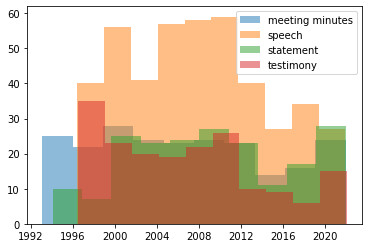

In [7]:
# show timing of types -- drop meeting transcripts due to delay in release, press conference transcripts as only began in 2011
plt.hist(text_data[text_data.type == 'minutes'].date, alpha = 0.5, label = 'meeting minutes')
plt.hist(text_data[text_data.type == 'speech'].date, alpha = 0.5, label = 'speech')
plt.hist(text_data[text_data.type == 'statement'].date, alpha = 0.5, label = 'statement')
plt.hist(text_data[text_data.type == 'testimony'].date, alpha = 0.5, label = 'testimony')

plt.legend()

## Keep only Meeting Minutes, Speech, Statement, Testimony

In [8]:
text_filtered = text_data[text_data.type.isin(['minutes', 'speech', 'statement', 'testimony'])]
text_filtered.shape

(1042, 11)

## Clean text

In [9]:
text_filtered.head(2)

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text
0,statement,1994-02-04,FOMC Statement,Alan Greenspan,99,1,3.25,1994-02-28,0,3.25,Chairman Alan Greenspan announced today that t...
1,statement,1994-03-22,FOMC Statement,Alan Greenspan,40,1,3.5,1994-04-18,1,3.75,Chairman Alan Greenspan announced today that t...


In [11]:
text_filtered['text_clean'] = text_filtered['text'].apply(clean) # clean text

text_filtered.head(1)

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_clean
0,statement,1994-02-04,FOMC Statement,Alan Greenspan,99,1,3.25,1994-02-28,0,3.25,Chairman Alan Greenspan announced today that t...,"[chairman, alan, greenspan, announced, today, ..."


## Split into Bigrams

In [12]:
corpus, id2word, bigram_text = get_corpus(text_filtered.text_clean)

In [15]:
corpus[0]

[(0, 1),
 (1, 1),
 (2, 1),
 (3, 1),
 (4, 1),
 (5, 1),
 (6, 1),
 (7, 1),
 (8, 1),
 (9, 1),
 (10, 1),
 (11, 1),
 (12, 1),
 (13, 1),
 (14, 1),
 (15, 1),
 (16, 1),
 (17, 1),
 (18, 1),
 (19, 1),
 (20, 1),
 (21, 1),
 (22, 1),
 (23, 1),
 (24, 1),
 (25, 1)]

## Apply LDA

### Choose number of topics

In [16]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=bigram_text, start=5, limit=30, step=2)

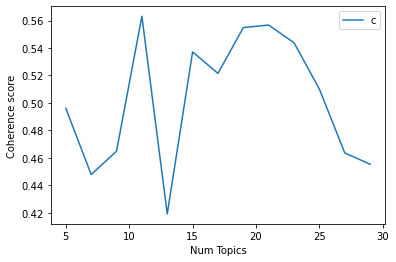

In [17]:
# Coherence score plot
limit=30; start=5; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

Choose 8 topics -- highest coherence score

### Model

In [18]:
# Number of Topics
num_topics = 8
# Build LDA model
lda_model_8 = gensim.models.LdaMulticore(corpus=corpus,
                                        id2word=id2word,
                                        num_topics=num_topics, 
                                        passes=50)

### Words in Topics

In [23]:
#pip install wordcloud

In [24]:
from wordcloud import WordCloud, STOPWORDS

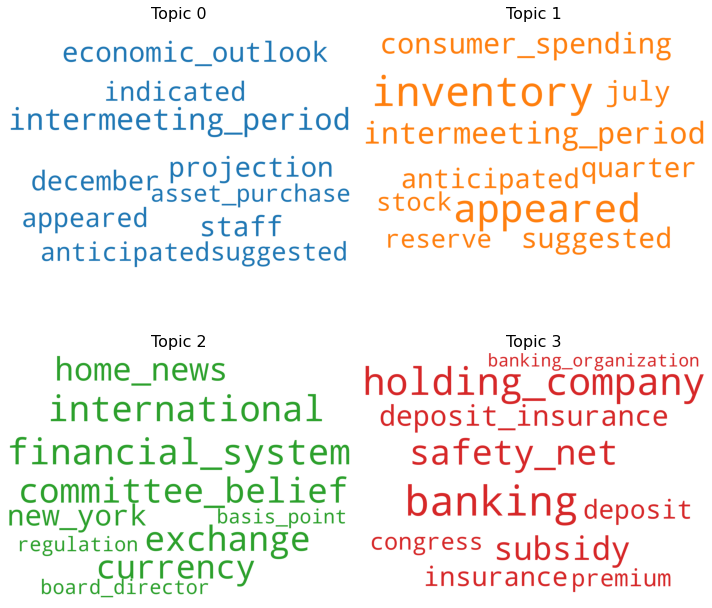

In [28]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=STOPWORDS,# changed for STOPWORDS
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model_8.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

### Keywords for each topic

In [29]:
# Print the Keyword in the topics
pprint(lda_model_8.print_topics())
doc_lda = lda_model_8[corpus]

[(0,
  '0.005*"intermeeting_period" + 0.004*"staff" + 0.004*"economic_outlook" + '
  '0.004*"projection" + 0.004*"december" + 0.004*"indicated" + '
  '0.004*"appeared" + 0.003*"anticipated" + 0.003*"suggested" + '
  '0.003*"asset_purchase"'),
 (1,
  '0.006*"inventory" + 0.005*"appeared" + 0.005*"intermeeting_period" + '
  '0.004*"consumer_spending" + 0.004*"suggested" + 0.004*"quarter" + '
  '0.004*"july" + 0.004*"anticipated" + 0.003*"reserve" + 0.003*"stock"'),
 (2,
  '0.006*"financial_system" + 0.006*"international" + 0.006*"exchange" + '
  '0.006*"committee_belief" + 0.005*"currency" + 0.005*"home_news" + '
  '0.005*"new_york" + 0.005*"board_director" + 0.005*"regulation" + '
  '0.005*"basis_point"'),
 (3,
  '0.025*"banking" + 0.024*"holding_company" + 0.020*"safety_net" + '
  '0.017*"subsidy" + 0.017*"deposit_insurance" + 0.015*"insurance" + '
  '0.015*"deposit" + 0.012*"premium" + 0.012*"congress" + '
  '0.010*"banking_organization"'),
 (4,
  '0.006*"education" + 0.005*"community

## Assess topic coherence

In [30]:
# Compute Perplexity
print('\nPerplexity: ', lda_model_8.log_perplexity(corpus))  # Measure of how good the model is. Lower is better.

# Compute Coherence Score
from gensim.models import CoherenceModel
coherence_model_lda = CoherenceModel(model=lda_model_8, texts=bigram_text, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda) # Want above .5


Perplexity:  -7.981747759334843

Coherence Score:  0.5468118392315657


In [31]:
# VISUALIZE LDA OUTPUT AS HTML-PAGE
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model_8, corpus, dictionary=lda_model_8.id2word)
vis

# output results
pyLDAvis.save_html(vis, '../img/bigram.lda8-50.html')

/Users/akalodzitsa/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/akalodzitsa/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/akalodzitsa/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/akalodzitsa/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/akalodzitsa/opt/anaconda3/lib/python3.9/site-

## Add LDA Topics to dataframe

In [32]:
# ADD LDA TOPICS TO DATAFRAME
# REFERENCE CODE: https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0

data = text_filtered['text_clean']
def format_topics_sentences(ldamodel=lda_model_8, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

# Run function to create new df
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model_8, corpus=corpus, texts=bigram_text)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

df_dominant_topic.head()


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,1.0,0.6191,"inventory, appeared, intermeeting_period, cons...","[chairman, alan_greenspan, announced, today, f..."
1,1,1.0,0.5185,"inventory, appeared, intermeeting_period, cons...","[chairman, alan_greenspan, announced, today, f..."
2,2,1.0,0.5568,"inventory, appeared, intermeeting_period, cons...","[chairman, alan_greenspan, announced, today, f..."
3,3,2.0,0.9326,"financial_system, international, exchange, com...","[taking_discount, action_board, approved_reque..."
4,4,2.0,0.6540,"financial_system, international, exchange, com...","[taking_discount, rate, action_board, approved..."


In [33]:
# This command prints out the topics in a text and the percent of the text from each topic

# if you want to make a list for each doc-topic pair
l = [lda_model_8.get_document_topics(item) for item in corpus]

# Create a list of lists (list of topics inside each doc)
topic_distribution = list()
for num in range(len(text_filtered['text_clean'])):
    props = [0] * 18  # create empty list
    doc = num
    for item in lda_model_8[corpus[num]]:
        topic = item[0]
        props[topic] = item[1]
    topic_distribution.append(props)
    
# Turn list of lists into dataframe
topic_dist = pd.DataFrame(topic_distribution)

In [34]:
# combine topics across transcript, minutes, etc. for each meeting date
final_text = text_filtered.join(topic_dist)
final_text = final_text.groupby('next_meeting').mean()

print(final_text.shape)
final_text.head()

(243, 20)


,word_count,next_rate,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
next_meeting,,,,,,,,,,,,,,,,,,,,
1993-02-18,8452.0,3.0,0.343412,0.613359,0.0,0.0,0.010092,0.0,0.016883,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1993-05-18,5253.0,3.0,0.066510,0.891975,0.0,0.0,0.000000,0.0,0.016912,0.024249,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1993-07-07,4414.0,3.0,0.053675,0.921525,0.0,0.0,0.000000,0.0,0.000000,0.018315,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1993-08-17,6309.0,3.0,0.071672,0.871647,0.0,0.0,0.000000,0.0,0.013781,0.038125,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1993-09-21,4220.0,3.0,0.062799,0.898115,0.0,0.0,0.019104,0.0,0.000000,0.019527,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [35]:
# find na's
na_rows = final_text[final_text.isna().any(axis=1)]

print(na_rows.shape)
display(na_rows)

(11, 20)


,word_count,next_rate,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
next_meeting,,,,,,,,,,,,,,,,,,,,
1998-09-29,1736.000000,5.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003-04-01,1802.000000,1.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003-04-08,1787.500000,1.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003-04-16,2315.000000,1.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003-05-06,864.000000,1.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-01-21,2805.000000,3.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-03-18,2733.000000,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-06-24,1502.333333,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-11-03,1844.333333,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
final_text = final_text.fillna(0)

In [37]:
# join LDA and nontext data
joined_data = final_text.join(nontext_data)

print(joined_data.shape)
joined_data.tail()

(243, 77)


,word_count,next_rate,0,1,2,3,4,5,6,7,...,Hsales_diff_year,Taylor,Balanced,Inertia,Taylor-Rate,Balanced-Rate,Inertia-Rate,Taylor_diff,Balanced_diff,Inertia_diff
next_meeting,,,,,,,,,,,,,,,,,,,,,
2021-06-16,2939.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.994247,0.0,0.0,...,4.119318,4.209310,2.794548,-0.419182,4.209310,2.794548,-0.419182,2.922618,2.794548,-0.419182
2021-07-28,2716.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.994045,0.0,0.0,...,-18.593564,4.771125,3.356363,-0.503454,4.771125,3.356363,-0.503454,0.561815,0.561815,-0.084272
2021-09-22,3146.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.990447,0.0,0.0,...,-31.627431,5.563014,4.720695,-0.708104,5.563014,4.720695,-0.708104,0.791889,1.364332,-0.204650
2021-11-03,2272.750000,0.0,0.0,0.0,0.0,0.0,0.0,0.989920,0.0,0.0,...,-25.540680,5.747177,4.940210,-0.741032,5.747177,4.940210,-0.741032,0.184163,0.219515,-0.032927
2021-12-15,1592.833333,0.0,0.0,0.0,0.0,0.0,0.0,0.993139,0.0,0.0,...,-13.988439,6.480214,5.673248,-0.850987,6.480214,5.673248,-0.850987,0.733037,0.733037,-0.109956


## Modify rate decision

In [39]:
# change target variable from -1 to 1 to 1 to 3
def convert_class(x):
    if x == 1:
        return 3
    elif x == 0:
        return 2
    elif x == -1:
        return 1

joined_data['RateDecision'] = joined_data.RateDecision.apply(convert_class)
joined_data['next_decision'] = joined_data['RateDecision'].shift(1)

# drop NA caused by shifting
joined_data = joined_data.dropna(subset = ['next_decision'])

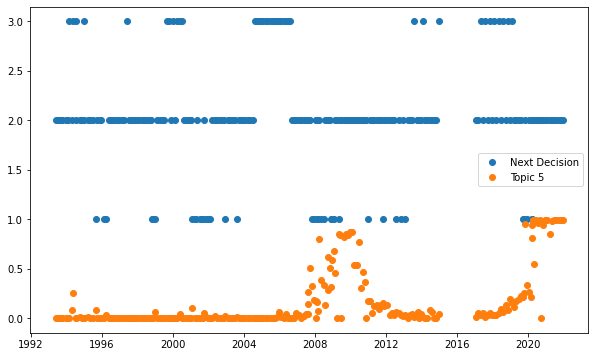

In [41]:
plt.figure(figsize=(10,6))
plt.plot(joined_data.index, joined_data.next_decision, 'o', label = 'Next Decision')
#plt.plot(joined_data.index, joined_data[0], 'o', label = 'Topic 0')
#plt.plot(joined_data.index, joined_data[1], 'o', label = 'Topic 1')
#plt.plot(joined_data.index, joined_data[2], 'o', label = 'Topic 2')
#plt.plot(joined_data.index, joined_data[3], 'o', label = 'Topic 3')
#plt.plot(joined_data.index, joined_data[4], 'o', label = 'Topic 4')
plt.plot(joined_data.index, joined_data[5], 'o', label = 'Topic 5')
#plt.plot(joined_data.index, joined_data[6], 'o', label = 'Topic 6')
#plt.plot(joined_data.index, joined_data[7], 'o', label = 'Topic 7')
plt.legend();

## Write data

In [42]:
def save_data(df, file_name, dir_name='../data/'):
    if not os.path.exists(dir_name):
        os.mkdir(dir_name)
        
    # Save results to a picke file
    file = open(dir_name + file_name + '.pickle', 'wb')
    pickle.dump(df, file)
    file.close()

    # Save results to a csv file
    df.to_csv(dir_name + file_name + '.csv', index=True)

In [43]:
# Final Text Data
save_data(final_text, 'text_w_lda')

# Final joined data
save_data(joined_data, 'final_fed_data')